Run endosome size and geometry analysis, on detected endosomes in dyn1 MINFLUX lipid tracking experiments.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import scipy
import math
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from sklearn.ensemble import IsolationForest
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'arial'

def consecutive_bool(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def reject_outliers(data, m = 3.):
    # from: https://stackoverflow.com/a/16562028
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

def get_membrane_pos(track_data, membrane='bottom'):
    # Get the position of the membrane (lowest peak in z-position histogram)
    z_tracks = track_data['z']
    all_z_pos = np.concatenate(z_tracks.to_numpy())
    hist = np.histogram(all_z_pos,bins=30)
    try:
        peaks = scipy.signal.find_peaks(hist[0], prominence=np.max(hist[0])/30)
        peaks_pos = [hist[1][peak] for peak in peaks[0]]
        if membrane=='bottom':
            main_membrane_pos = np.min(peaks_pos)
        elif membrane=='top':
            main_membrane_pos = np.max(peaks_pos)
    except:
        main_membrane_pos = 0
    return main_membrane_pos

def sphereFit(spX,spY,spZ):
    #   Assemble the A matrix
    spX = np.array(spX)
    spY = np.array(spY)
    spZ = np.array(spZ)
    A = np.zeros((len(spX),4))
    A[:,0] = spX*2
    A[:,1] = spY*2
    A[:,2] = spZ*2
    A[:,3] = 1

    #   Assemble the f matrix
    f = np.zeros((len(spX),1))
    f[:,0] = (spX*spX) + (spY*spY) + (spZ*spZ)
    C, _, _, _ = np.linalg.lstsq(A,f,rcond=0)

    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = math.sqrt(t)

    return radius, C[0], C[1], C[2]

def doubleGaussian(z, amplitude1, amplitude2, zo1, zo2, sigma1, sigma2, offset):
    zo1 = float(zo1)
    zo2 = float(zo2)
    g = offset + amplitude1*np.exp(-(((z-zo1)/sigma1)**2)) + amplitude2*np.exp(-(((z-zo2)/sigma2)**2))
    return g.ravel()

def gaussian(z, amplitude, zo, sigma, offset):
    zo = float(zo)
    g = offset + amplitude*np.exp(-(((z-zo)/sigma)**2))
    return g.ravel()

def extract_endosome_clusters(x,y,z, eps=0.04, minsamples=100):
    # cluster algorithm on x,y,z localizations
    X = np.vstack((x, y, z))
    X = np.swapaxes(X, 0, 1)
    # cluster
    db = DBSCAN(eps=eps, min_samples=minsamples).fit(X)
    return db.labels_

def get_artefactfiltered_pos(track_data, cycle):
    xtracks = track_data[track_data['cycle']==cycle]['x']
    ytracks = track_data[track_data['cycle']==cycle]['y']
    ztracks = track_data[track_data['cycle']==cycle]['z']
    dtartefactsmasktracks = track_data[track_data['cycle']==cycle]['dt_artefacts_mask']
    x_filt = np.concatenate([xtrack[artefactmask] for xtrack,artefactmask in zip(xtracks,dtartefactsmasktracks)])
    y_filt = np.concatenate([ytrack[artefactmask] for ytrack,artefactmask in zip(ytracks,dtartefactsmasktracks)])
    z_filt = np.concatenate([ztrack[artefactmask] for ztrack,artefactmask in zip(ztracks,dtartefactsmasktracks)])
    return x_filt, y_filt, z_filt

def get_membrane_pos_mod(z, max_peak_bool=False, model='double', initpeakposguess=[-0.02, 0.02]):
    # get z-histogram
    hist = np.histogram(z,bins=90)
    if model=='single':
        # single gaussian fit
        initial_guess = (np.max(hist[0]), -0.1, 0.05, 0)
        popt, _ = scipy.optimize.curve_fit(gaussian, hist[1][:-1]+(hist[1][1]-hist[1][0])/2, hist[0], p0=initial_guess)
        memb_pos = popt[1]
        memb_sigma = np.abs(popt[-2])
    elif model=='double':
        # double gaussian fit
        initial_guess = (np.max(hist[0]), np.max(hist[0])/2, *initpeakposguess, 0.05, 0.1, 0)
        popt, _ = scipy.optimize.curve_fit(doubleGaussian, hist[1][:-1]+(hist[1][1]-hist[1][0])/2, hist[0], p0=initial_guess)
        peaks_pos = popt[2:4]
        if max_peak_bool:
            memb_pos = np.max(peaks_pos)
        else:
            memb_pos = np.min(peaks_pos)
        memb_sigma = np.abs(popt[-3])
    return memb_pos, memb_sigma

def get_membfiltered_pos(x_arr, y_arr, z_arr, memb_pos, memb_sigma, memb_sigma_factor=1):
    # filter localizations, get all above membrane+~half membrane width (1*sigma)
    memb_top = memb_pos + memb_sigma*memb_sigma_factor

    z_filt = np.array([z for z in z_arr if z>memb_top])
    x_filt = np.array([x for x,z in zip(x_arr,z_arr) if z>memb_top])
    y_filt = np.array([y for y,z in zip(y_arr,z_arr) if z>memb_top])
    return x_filt, y_filt, z_filt

def get_endosomeclusterfilt_pos(x, y, z, endosome_cluster_label=0,minsample=100):
    # get endosome clusters
    labels = extract_endosome_clusters(x,y,z,minsamples=minsample)
    x_filt = x[labels==endosome_cluster_label]
    y_filt = y[labels==endosome_cluster_label]
    z_filt = z[labels==endosome_cluster_label]
    return x_filt, y_filt, z_filt

def get_outlierfilt_pos(x, y, z):
    ## FIND AND REMOVE OUTLIERS
    X = np.vstack((x, y, z)).T
    clf = IsolationForest(n_estimators=10, contamination=0.25)
    outlierlabels = clf.fit_predict(X);
    x_filt = x[outlierlabels==1]
    y_filt = y[outlierlabels==1]
    z_filt = z[outlierlabels==1]
    x_outl = x[outlierlabels==-1]
    y_outl = y[outlierlabels==-1]
    z_outl = z[outlierlabels==-1]
    return x_filt, y_filt, z_filt, x_outl, y_outl, z_outl
    
def convexhull_fit(x, y, z, memb_pos):
    peroxisome_positions = np.swapaxes(np.vstack([x, y, z]),0,1)
    convex_hull = ConvexHull(peroxisome_positions)
    area = convex_hull.area
    volume = convex_hull.volume
    sphericity = ((np.pi**(1/3))*(6*volume)**(2/3))/area
    
    ch_centroid = [np.mean(convex_hull.points[convex_hull.vertices,0]), np.mean(convex_hull.points[convex_hull.vertices,1]), np.mean(convex_hull.points[convex_hull.vertices,2])]
    endo_diameter = 2*(3*volume/(4*np.pi))**(1./3)
    neck_length = ch_centroid[2]-memb_pos-endo_diameter/2
    return area, volume, sphericity, endo_diameter, neck_length, convex_hull

def plot_fitting_results(folder, cycle, x_endosome, y_endosome, z_endosome, all_x, all_y, all_z, x_endosome_outliers, y_endosome_outliers, z_endosome_outliers, convex_hull):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    ## PLOT RAW POINTS IN DATASET
    filt = [x not in x_endosome for x in all_x]
    ax.scatter(all_x[filt], all_y[filt], all_z[filt], zdir='z', s=4, c='k',rasterized=True, alpha=0.1)

    ## PLOT Z-FILTERED AND CLUSTERED POINTS, CLEANED AND OUTLIERS
    ax.scatter(x_endosome, y_endosome, z_endosome, zdir='z', s=8, c='b',rasterized=True, alpha=0.1)
    ax.scatter(x_endosome_outliers, y_endosome_outliers, z_endosome_outliers, zdir='z', s=8, c='r',rasterized=True, alpha=0.05)

    ## PLOT CONVEX HULL
    points = convex_hull.points
    for simplex in convex_hull.simplices:
        simplex = np.append(simplex, simplex[0])
        ax.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], 'm-', alpha=0.4)

    ax.set_xlabel('$x$ (um)')
    ax.set_ylabel('\n$y$ (um)')
    ax.set_zlabel('\n$z$ (um)')
    ax.set_aspect('equal')
    ax.view_init(10,70)
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(os.path.join(folder,f"plot-endosomefitting-cycle{cycle}.pdf"))
    for i in plt.get_fignums():
        pdf.savefig(i)
    pdf.close()
    
    plt.close('all')
    
def get_track_data(folder, loc_it=4, window_pts=70, dt_loc_thresh=550):
    filelist = os.listdir(folder)
    filelist_npy = [file for file in filelist if file.endswith('.npy')]

    track_data = pd.DataFrame(columns=['cycle', 'tridx', 'tim0', 'x', 'y', 'z', 'tim', 'dt', 'efo', 'lims', 'z1', 'z1_diff', 'z_std', 'z_range', 'dt_artefacts_mask'])
    file_idx_npy = 0
    for file_idx_npy in range(len(filelist_npy)):

        file_npy = os.path.join(folder, filelist_npy[file_idx_npy])
        dataset = np.load(file_npy)

        x = np.zeros((len(dataset),1))
        y = np.zeros((len(dataset),1))
        z = np.zeros((len(dataset),1))
        z1 = np.zeros((len(dataset),1))
        tid = np.zeros((len(dataset),1))
        tim = np.zeros((len(dataset),1))
        efo = np.zeros((len(dataset),1))
        for i in range(len(dataset)):
            x[i] = dataset[i][0][loc_it][2][0]
            y[i] = dataset[i][0][loc_it][2][1]
            z[i] = dataset[i][0][loc_it][2][2]
            z1[i] = dataset[i][0][1][2][2]
            efo[i] = dataset[i][0][loc_it][6]
            tid[i] = dataset[i][4]
            tim[i] = dataset[i][3]
        x = x * 1e6
        x = x.flatten()
        y = y * 1e6
        y = y.flatten()
        z = z * 1e6
        z = z * 0.7  # z scaling for immersion mismatch
        z = z.flatten()
        z1 = z1 * 1e6
        z1 = z1.flatten()
        tid = tid.flatten()
        tim = tim.flatten()
        efo = efo.flatten()
        track_ids = list(map(int, set(tid)))
        track_ids.sort()
        for track in track_ids[::]:
            data_row = []
            x_track = np.array([val for val,tr in zip(x,tid) if tr==track]).flatten()
            y_track = np.array([val for val,tr in zip(y,tid) if tr==track]).flatten()
            z_track = np.array([val for val,tr in zip(z,tid) if tr==track]).flatten()
            z1_track = np.array([val for val,tr in zip(z1,tid) if tr==track]).flatten()
            tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
            efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
            z_diff = z_track - z1_track[0]
            
            dt_track_full = np.diff(tim_track)*1e6
            dt_track_full = np.insert(dt_track_full,0,0)
            if len(dt_track_full) > window_pts:
                local_dt_full = []
                for i in np.arange(0, len(dt_track_full)):
                    if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                        local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
                    elif i <= int(window_pts/2):
                        local_dt_full.append(np.mean(dt_track_full[0:i+int(window_pts/2)]))
                    elif i >= len(dt_track_full)-int(window_pts/2)-1:
                        local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):]))
                    else:
                        local_dt_full.append(0)
                local_dt_full = np.array(local_dt_full)
                dt_artefacts_mask = local_dt_full<dt_loc_thresh
            else:
                dt_artefacts_mask = np.full(len(dt_track_full), False)
            
            data_row.append(file_idx_npy)
            data_row.append(track)
            data_row.append(tim_track[0])
            data_row.append(x_track)
            data_row.append(y_track)
            data_row.append(z_track)
            tim_track = tim_track - tim_track[0]
            data_row.append(tim_track)
            data_row.append(np.diff(tim_track))
            data_row.append(efo_track)
            data_row.append([np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)])
            data_row.append(z1_track)
            data_row.append(z_diff)
            data_row.append(np.std(z_track))
            data_row.append(np.max(z_track)-np.min(z_track))
            data_row.append(dt_artefacts_mask)
            track_data = pd.concat([track_data, pd.DataFrame([data_row], columns=track_data.columns)], ignore_index=True)
    return track_data

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [ ]:
### Run analysis on all dyn1 events with vesicles, and extract vesicle sizes, neck lengths, and vesicle shapes
%matplotlib agg
%matplotlib agg

topfolders = [os.path.join(parentdir, 'exampledata\\dyn1\\241101'),
              os.path.join(parentdir, 'exampledata\\dyn1\\241121')]

endosome_data = pd.DataFrame(columns=['folder','cycle','memb_pos','memb_sigma','area','volume','sphericity','diameter','neck_length'])

for topfolder in topfolders:
    print(topfolder)
    eventfolders_all = []
    samplefolders = os.listdir(topfolder)
    for samplefolder in samplefolders:
        if os.path.isdir(os.path.join(topfolder,samplefolder)):
            cellfolders = os.listdir(os.path.join(topfolder,samplefolder))
            for cellfolder in cellfolders:
                eventfolders = os.listdir(os.path.join(topfolder,samplefolder,cellfolder))
                for eventfolder in eventfolders:
                    if 'nomfx' not in eventfolder:
                        eventfolders_all.append(os.path.join(topfolder,samplefolder,cellfolder, eventfolder))
                        
    # analysis parameters for running on the example dataset of detected endosomes
    if '241101' in topfolder:
        cycles = [0,0]
        dt_threshs = [550,550]
        memb_sigma_factors = [1,0.5]
        endosome_cluster_labels = [0,0]
        fitmodels = ['double','double']
        initpeakposguesses = [[-0.02, 0.02],[-0.02, 0.02]]
        max_peak_membrane_pos = [False, False]
        minsamples = [100, 100]
    elif '241121' in topfolder:
        cycles = [0,0]
        dt_threshs = [550,550]
        memb_sigma_factors = [2,2]
        endosome_cluster_labels = [0,0]
        initpeakposguesses = [[-0.02, 0.02],[-0.02, 0.02]]
        fitmodels = ['single','double']
        max_peak_membrane_pos = [False, False]
        minsamples = [100, 100]
        minsamples = [100,100,100,100,100,100,100,50]

    # analysis parameters for running on the full dataset of detected endosomes
    # if '241101' in topfolder:
    #         cycles = [0,0,0,3,0,0,0,1,0,0,0]
    #         dt_threshs = [550,550,550,550,550,550,550,550,550,550,550]
    #         memb_sigma_factors = [1,-0.5,0.5,7,1,0.5,6,0.5,2.8,1,-1.7]
    #         endosome_cluster_labels = [0,0,0,0,0,0,0,0,0,1,0]
    #         fitmodels = ['double','double','double','double','double','double','double','double','double','double','double']
    #         initpeakposguesses = [[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02]]
    #         max_peak_membrane_pos = [False, False, False, False, False, False, False, True, False, False, False]
    #         minsamples = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
    #     elif '241031' in topfolder:
    #         cycles = [0,0,0,0,0,0,0,0,0,0]
    #         dt_threshs = [550,550,550,550,550,550,550,550,550,550]
    #         memb_sigma_factors = [1.3,2.5,1,1,1,3,1,1,1,1]
    #         endosome_cluster_labels = [2,0,2,0,0,0,0,0,0,1]
    #         initpeakposguesses = [[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[0.05, 0.15],[-0.02, 0.02]]
    #         fitmodels = ['double','double','double','double','single','double','double','double','double','double']
    #         max_peak_membrane_pos = [False, False, False, False, False, False, False, False, False, False, False]
    #         minsamples = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
    #     elif '241121' in topfolder:
    #         cycles = [0,0,0,1,5,0,0,0,0,0,0,1,0,0,0,1]
    #         dt_threshs = [550,550,550,550,550,550,550,550,550,550,550,550,550,550,550,550]
    #         memb_sigma_factors = [1,3,1,1,2,1,1,1,1,2,2,3,0.5,1.5,0.6,0.4]
    #         endosome_cluster_labels = [0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
    #         initpeakposguesses = [[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02]]
    #         fitmodels = ['double','double','double','double','double','double','double','double','double','single','double','double','double','double','single','double']
    #         max_peak_membrane_pos = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
    #         minsamples = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 40]
    #     elif '241122' in topfolder:
    #         cycles = [0,0,0,0,0,0,5,0]
    #         dt_threshs = [550,550,550,550,550,550,550,550]
    #         memb_sigma_factors = [1,0.7,1,1,1,1,1,1.5]
    #         endosome_cluster_labels = [0,0,0,0,2,0,0,0]
    #         initpeakposguesses = [[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02],[-0.02, 0.02]]
    #         fitmodels = ['double','double','double','double','double','double','double','double']
    #         max_peak_membrane_pos = [False, False, False, False, False, False, False, False]
    #         minsamples = [100,100,100,100,100,100,100,50]

    for folder, cycle, memb_sigma_factor, dt_loc_thresh, endosome_cluster_label, max_peak_bool, fitmodel, initpeakposguess, minsample in zip(eventfolders_all, cycles, memb_sigma_factors, dt_threshs, endosome_cluster_labels, max_peak_membrane_pos, fitmodels, initpeakposguesses, minsamples):
        track_data = get_track_data(folder, dt_loc_thresh=dt_loc_thresh)
        data_row = []
        try:
            all_x,all_y,all_z = get_artefactfiltered_pos(track_data, cycle)
            memb_pos, memb_sigma = get_membrane_pos_mod(all_z, max_peak_bool=max_peak_bool, model=fitmodel, initpeakposguess=initpeakposguess)
            x_membfilt,y_membfilt,z_membfilt = get_membfiltered_pos(all_x, all_y, all_z, memb_pos, memb_sigma, memb_sigma_factor)
            x_endoclusterfilt,y_endoclusterfilt,z_endoclusterfilt = get_endosomeclusterfilt_pos(x_membfilt, y_membfilt, z_membfilt, endosome_cluster_label, minsample)
            x_endosome,y_endosome,z_endosome,x_endosome_outliers,y_endosome_outliers,z_endosome_outliers = get_outlierfilt_pos(x_endoclusterfilt, y_endoclusterfilt, z_endoclusterfilt)
            area, volume, sphericity, endo_diameter, neck_length, convex_hull = convexhull_fit(x_endosome, y_endosome, z_endosome, memb_pos)
            plot_fitting_results(folder, cycle, x_endosome, y_endosome, z_endosome, all_x, all_y, all_z, x_endosome_outliers, y_endosome_outliers, z_endosome_outliers, convex_hull)
            
            print(f'Area: {area} µm^2, volume: {volume} µm^3, sphericity: {sphericity:.2f}, endosome diameter: {endo_diameter*1e3:.0f} nm, neck length: {neck_length*1e3:.0f} nm')
            data_row.append('\\'.join(folder.split('\\')[-4:]))
            data_row.append(cycle)
            data_row.append(memb_pos)
            data_row.append(memb_sigma)
            data_row.append(area)
            data_row.append(volume)
            data_row.append(sphericity)
            data_row.append(endo_diameter*1e3)
            data_row.append(neck_length*1e3)
            endosome_data = pd.concat([endosome_data, pd.DataFrame([data_row], columns=endosome_data.columns)], ignore_index=True)
        except:
            print('Failed extraction')
            data_row.append('\\'.join(folder.split('\\')[-4:]))
            data_row.append(np.nan)
            data_row.append(np.nan)
            data_row.append(np.nan)
            data_row.append(np.nan)
            data_row.append(np.nan)
            data_row.append(np.nan)
            data_row.append(np.nan)
            data_row.append(np.nan)
            endosome_data = pd.concat([endosome_data, pd.DataFrame([data_row], columns=endosome_data.columns)], ignore_index=True)


c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101
Area: 0.043126322944281564 µm^2, volume: 0.0007728614833290409 µm^3, sphericity: 0.94, endosome diameter: 114 nm, neck length: 19 nm
Area: 0.01814499866766606 µm^2, volume: 0.00018502759013726668 µm^3, sphericity: 0.87, endosome diameter: 71 nm, neck length: 29 nm
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241121
Area: 0.03218557394056121 µm^2, volume: 0.0004838091268224314 µm^3, sphericity: 0.93, endosome diameter: 97 nm, neck length: 48 nm
Area: 0.03982553608254942 µm^2, volume: 0.0006430409830439279 µm^3, sphericity: 0.90, endosome diameter: 107 nm, neck length: 34 nm


In [5]:
endosome_data

,folder,cycle,memb_pos,memb_sigma,area,volume,sphericity,diameter,neck_length
0,241101\sample1\cell2\e1,0,-0.024585,0.024132,0.043126,0.000773,0.944371,113.859083,19.490056
1,241101\sample1\cell2\e2,0,0.031658,0.085357,0.018145,0.000185,0.865403,70.698895,29.158609
2,241121\sample2\cell3\e1,0,-0.059394,0.017912,0.032186,0.000484,0.925988,97.399893,47.871801
3,241121\sample2\cell3\e2,0,-0.062815,0.024724,0.039826,0.000643,0.904652,107.089447,33.937621


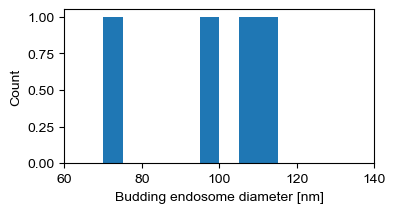

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'arial'

savefolder = '\\'.join(topfolders[0].split('\\')[:-2])

plt.figure(figsize=(4,2))
plt.hist(endosome_data['diameter'], bins=np.linspace(60,140,17))
plt.xlabel('Budding endosome diameter [nm]')
plt.ylabel('Count')
plt.xlim([60,140])
savename = f'endosome-diameter'
plt.savefig(os.path.join(savefolder,savename+'.svg'), format="svg", bbox_inches="tight")

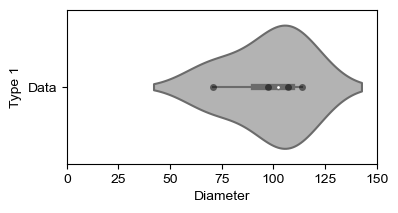

In [7]:
# sample data
diameterdata = {'Type 1': ['Data'] * len(endosome_data['diameter']),
         'Diameter': np.array(endosome_data['diameter'])}
df = pd.DataFrame(diameterdata)
# plot
plt.figure(figsize=[4,2])
my_palette = {'Data': (0.7,0.7,0.7)}
sns.swarmplot(y='Type 1', x='Diameter', data=df, color='#000000', size=5, alpha=0.5)
sns.violinplot(y='Type 1', x='Diameter', data=df, inner='box', palette=my_palette)
plt.xlim([0, 150])

savename = f'endosome-diameter-violin'
plt.savefig(os.path.join(savefolder,savename+'.svg'), format="svg", bbox_inches="tight")

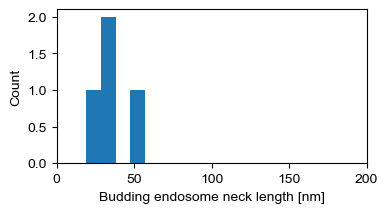

In [8]:
neck_lengths = [nl if nl>0 else 0 for nl in endosome_data['neck_length']]

plt.figure(figsize=(4,2))
plt.hist(neck_lengths, bins=np.linspace(0,200,22))
plt.xlabel('Budding endosome neck length [nm]')
plt.ylabel('Count')
plt.xlim([0, 200])
plt.show()

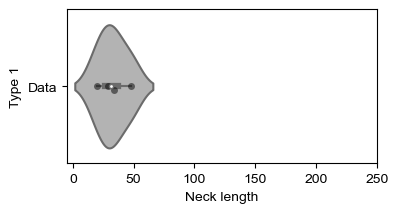

In [9]:
# sample data
neck_lengths = [nl if nl>0 else 0 for nl in endosome_data['neck_length']]
nldata = {'Type 1': ['Data'] * len(neck_lengths),
         'Neck length': np.array(neck_lengths)}
df = pd.DataFrame(nldata)

# plot
plt.figure(figsize=[4,2])
my_palette = {'Data': (0.7,0.7,0.7)}
sns.swarmplot(y='Type 1', x='Neck length', data=df, color='#000000', size=5, alpha=0.5)
sns.violinplot(y='Type 1', x='Neck length', data=df, inner='box', palette=my_palette)
plt.xlim([-5,250])
plt.show()

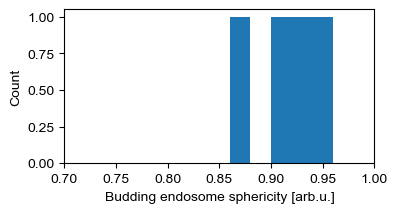

In [10]:
plt.figure(figsize=(4,2))
plt.hist(endosome_data['sphericity'], bins=np.linspace(0.7,1.0,16))
plt.xlabel('Budding endosome sphericity [arb.u.]')
plt.ylabel('Count')
plt.xlim([0.7,1.0])
plt.show()

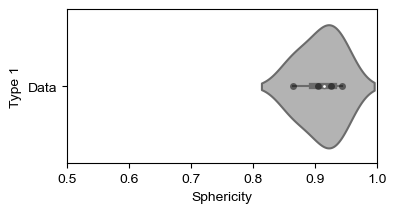

In [11]:
# sample data
nldata = {'Type 1': ['Data'] * len(endosome_data['sphericity']),
         'Sphericity': np.array(endosome_data['sphericity'])}
df = pd.DataFrame(nldata)
# plot
plt.figure(figsize=[4,2])
my_palette = {'Data': (0.7,0.7,0.7)}
sns.swarmplot(y='Type 1', x='Sphericity', data=df, color='#000000', size=5, alpha=0.5)
sns.violinplot(y='Type 1', x='Sphericity', data=df, inner='box', palette=my_palette)
plt.xlim([0.5, 1])
plt.show()

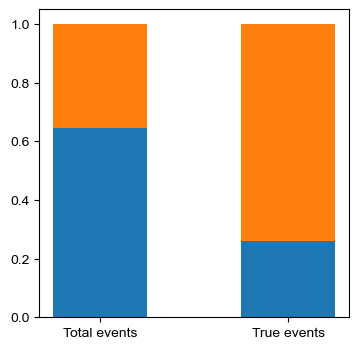

In [ ]:
### EVENT STATISTICS
tot_events = 155
valid_events = 100
great_events = 32
valid_events_overlapping_ves = 26
non_valid_events_overlapping_ves = 6
great_events_great_ves = 11

events_one_cycle = 14
events_two_cycle = 4
events_three_cycle = 4
events_arrested = 4

cat = ("Total events", "True events")
counts = {"True": np.array([valid_events/tot_events, valid_events_overlapping_ves/valid_events]), "False": np.array([(tot_events-valid_events)/tot_events, (valid_events-valid_events_overlapping_ves)/valid_events])}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)
for boolean, counts in counts.items():
    p = ax.bar(cat, counts, width, label=boolean, bottom=bottom)
    bottom += counts
fig.set_size_inches(4, 4)
plt.show()

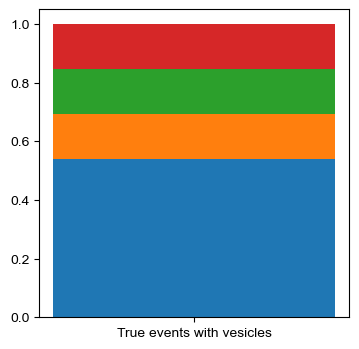

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'arial'

cat = ("True events with vesicles")
counts = {"One cycle": np.array([events_one_cycle/valid_events_overlapping_ves]), "Two cycles": np.array([events_two_cycle/valid_events_overlapping_ves]), "Three+ cycles": np.array([events_three_cycle/valid_events_overlapping_ves]), "Arrested": np.array([events_arrested/valid_events_overlapping_ves])}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)
for boolean, count in counts.items():
    p = ax.bar(cat, count, width, label=boolean, bottom=bottom)
    bottom += count
fig.set_size_inches(4, 4)
plt.show()